In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import leidenalg
import igraph as ig

In [47]:
import sys

In [4]:
#
sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=80) 
sc.logging.print_versions() 
import os 
os.getcwd() 
os.chdir('/OceanStor100D/home/xx/bone_metastatic/new_analysis/scanpy_result/test') 
os.getcwd()
results_file = 'pbmc3k.h5ad' 

-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                         8.3.2
anndata                     0.7.6
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.14.6
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2021.09.1
dateutil                    2.8.2
debugpy                     1.4.1
decorator                   5.1.0
defusedxml                  0.7.1
dunamai                     1.6.0
entrypoints                 0.3
fsspec                      2021.09.0
get_version                 3.5
h5py                        2.10.0
igraph                      0.9.9
ipykernel                   6.4.1
ipython_genutils            0.2.0
jedi                        0.18.0
jinja2                      3.0.1
joblib                      1.0.1
kiwisolver      

normalizing counts per cell
    finished (0:00:00)


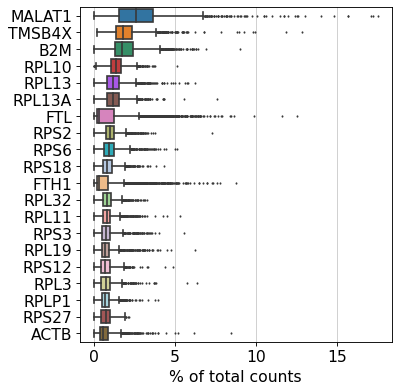

filtered out 19024 genes that are detected in less than 3 cells


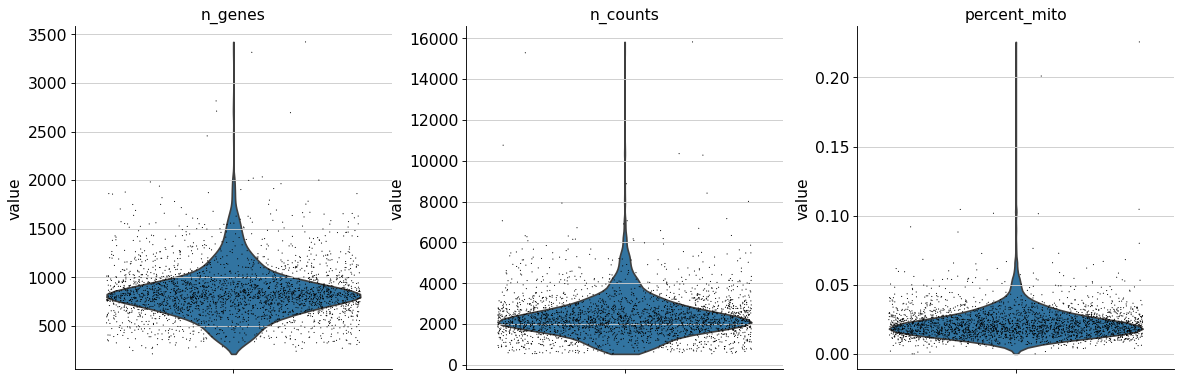

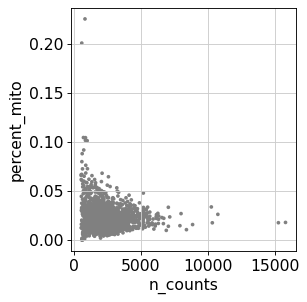

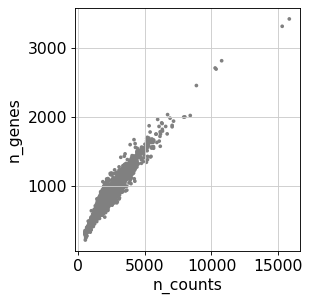

In [29]:
#preparing data
sc.pl.highest_expr_genes(adata, n_top=20, ) 
#help(sc.pl.highest_expr_genes)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

#sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
#help(sc.pp.calculate_qc_metrics)

mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

adata = adata[adata.obs.n_genes < 9000, :]
adata = adata[adata.obs.percent_mito < 0.1, :]  



In [30]:
#数据标准化
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/OceanStor100D/home/sunyidi_lab/ymhuang/anaconda2/envs/SC_scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


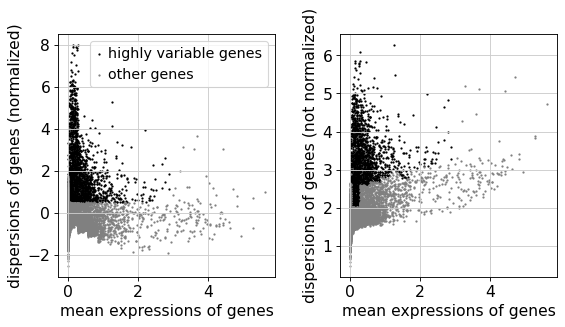

In [31]:
#Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# help(sc.pp.highly_variable_genes)
sc.pl.highly_variable_genes(adata)

adata.raw = adata 
adata.raw.to_adata() 

adata = adata[:, adata.var['highly_variable']]


In [32]:
#HVG & scale
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) 

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


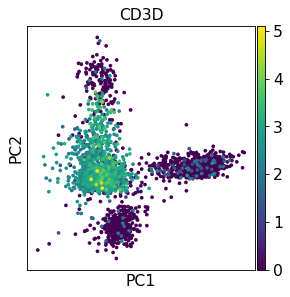

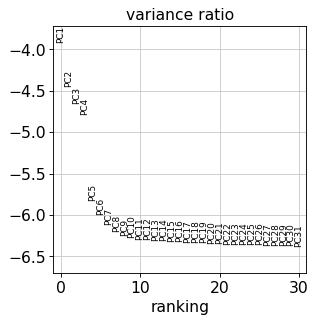

In [33]:
#PCA
sc.tl.pca(adata, svd_solver='arpack') 
sc.pl.pca(adata, color='CD3D') #a scatter plot in the PCA coordinates
sc.pl.pca_variance_ratio(adata, log=True)
adata.write(results_file)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


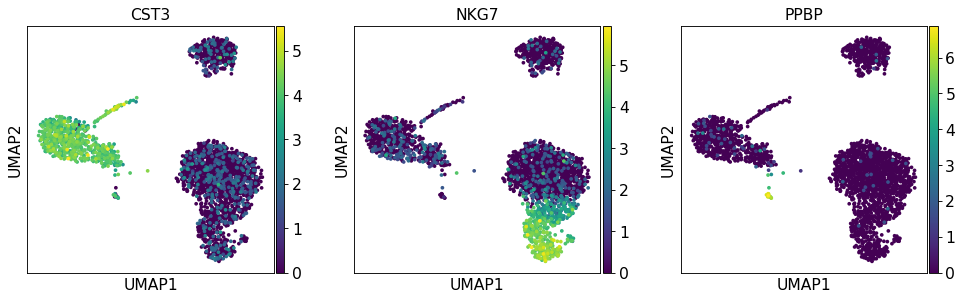

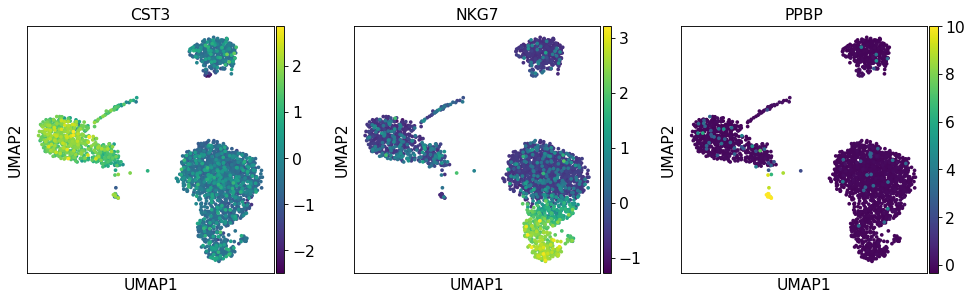

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


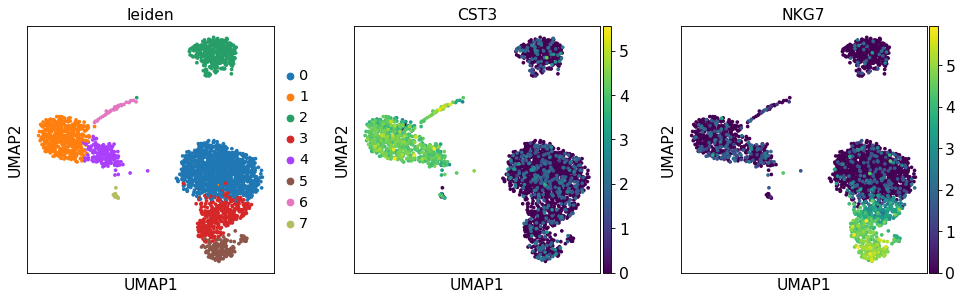

In [34]:
#Clustering
#Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10,n_pcs=40) 
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)
sc.tl.leiden(adata)    
#sc.tl.louvain(adata) 
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
adata.write(results_file) 


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


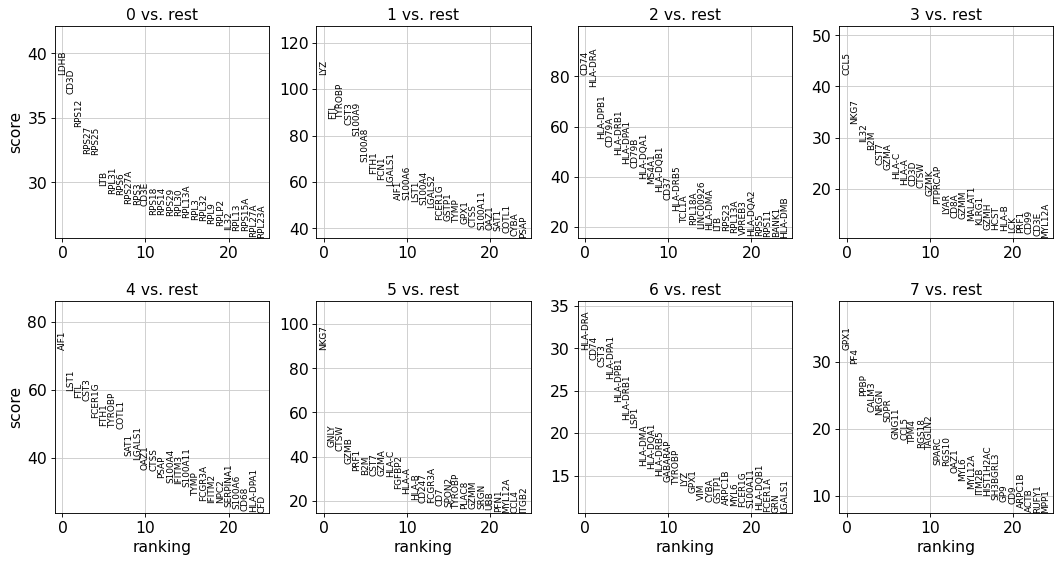

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


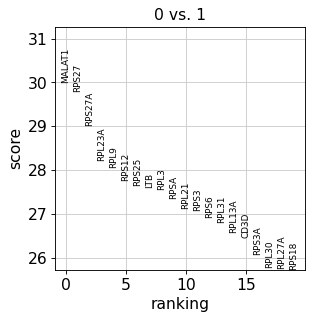

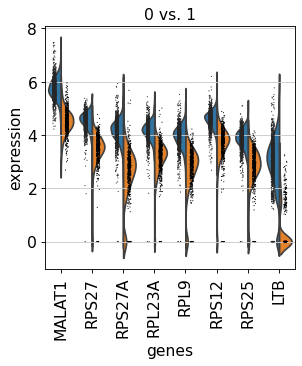

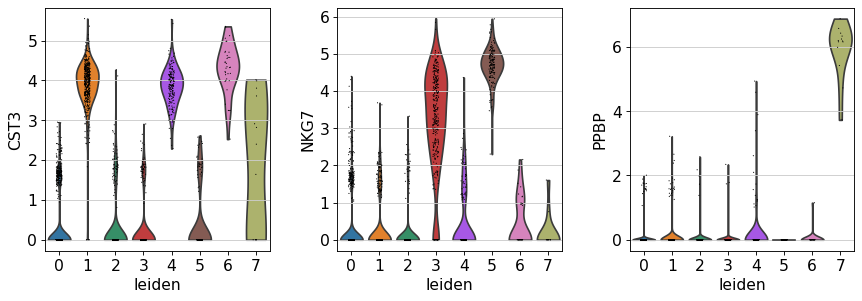

In [37]:
#Finding marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') #'t-test'`,`'t-test_overestim_var'`,`'wilcoxon',and 'logreg'
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.get.rank_genes_groups_df(adata, group="0") 
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5) 

pd.DataFrame(    {group + '_' + key[:1]: result[key][group]    for group in groups for key in ['names', 'pvals']}).head(5)
res = pd.DataFrame(    {group + '_' + key: result[key][group]    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})
res.to_csv("dif.csv") 

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon') 
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8) #小提琴图展示差异基因表达情况，注意上一步的比较对象，0 vs 1还是0 vs rest

sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden') # 小提琴图展示某一基因在不同群中的表达情况

In [41]:
#Rename
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

#adata.obs['cell type']=adata.obs['clusters'].map(new_cluster_names).astype('category') 

sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


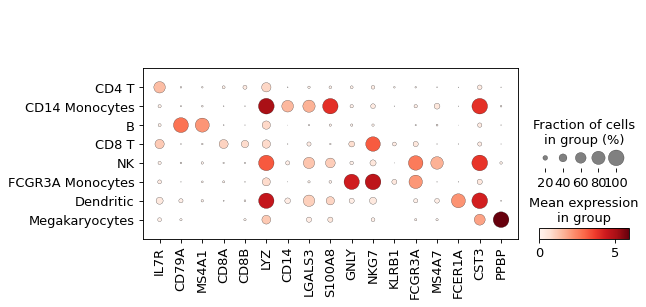

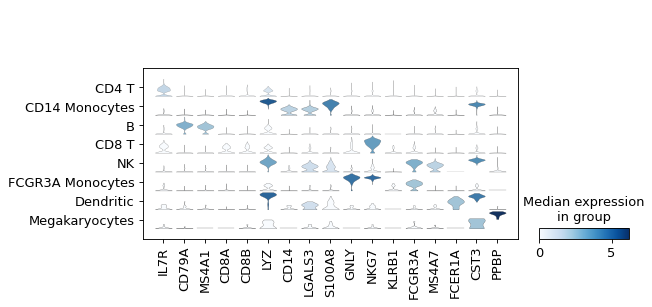

In [44]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
sc.pl.dotplot(adata, marker_genes, groupby='leiden');
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


In [45]:
adata

AnnData object with n_obs × n_vars = 2689 × 1860
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'clusters'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#Saving data
adata.write(results_file, compression='gzip') 
adata.raw.to_adata().write('./write/mBone_withoutX.h5ad')#contains the raw data used in the visualizations in adata.raw
# Export single fields of the annotation of observations
adata.obs[['n_counts', 'louvain_groups']].to_csv(
    './write/mBone_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    './write/mBone_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata.write_csvs(results_file[:-5], )